스케일 처리된 파일 읽어오기 - scaled_by_skweness_and_kurtosis.csv

## 필수 라이브러리 임포트

In [33]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.metrics import (
    confusion_matrix, classification_report, accuracy_score, 
    roc_curve, roc_auc_score, precision_score, recall_score, f1_score
)
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, ADASYN



In [3]:
# CSV 파일 경로 설정
data_path = 'final_VIF_Delete.csv'

# 데이터 불러오기
df = pd.read_csv(data_path)

# 'Unnamed: 0' 열 제거
if 'Unnamed: 0' in df.columns:
    df = df.drop(columns=['Unnamed: 0'])

# 데이터의 처음 몇 행을 확인
print(df.head())

   TARGET  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  \
0       1                   0            0             0                1   
1       1                   0            1             0                1   
2       1                   0            0             0                1   
3       1                   0            1             0                0   
4       1                   0            1             0                1   

   CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  NAME_TYPE_SUITE  \
0           0.0             0.615   -0.198521    -0.011205              0.0   
1           0.0            -0.385    0.865982     0.120269              0.0   
2           0.0             0.615    1.262506     0.560259              0.0   
3           0.0            -0.135   -0.417076    -0.478337              0.0   
4           0.0            -0.735   -0.485530    -0.570468              0.0   

   ...  FLAG_DOCUMENT_19  FLAG_DOCUMENT_20  FLAG_DOCUMENT_21  

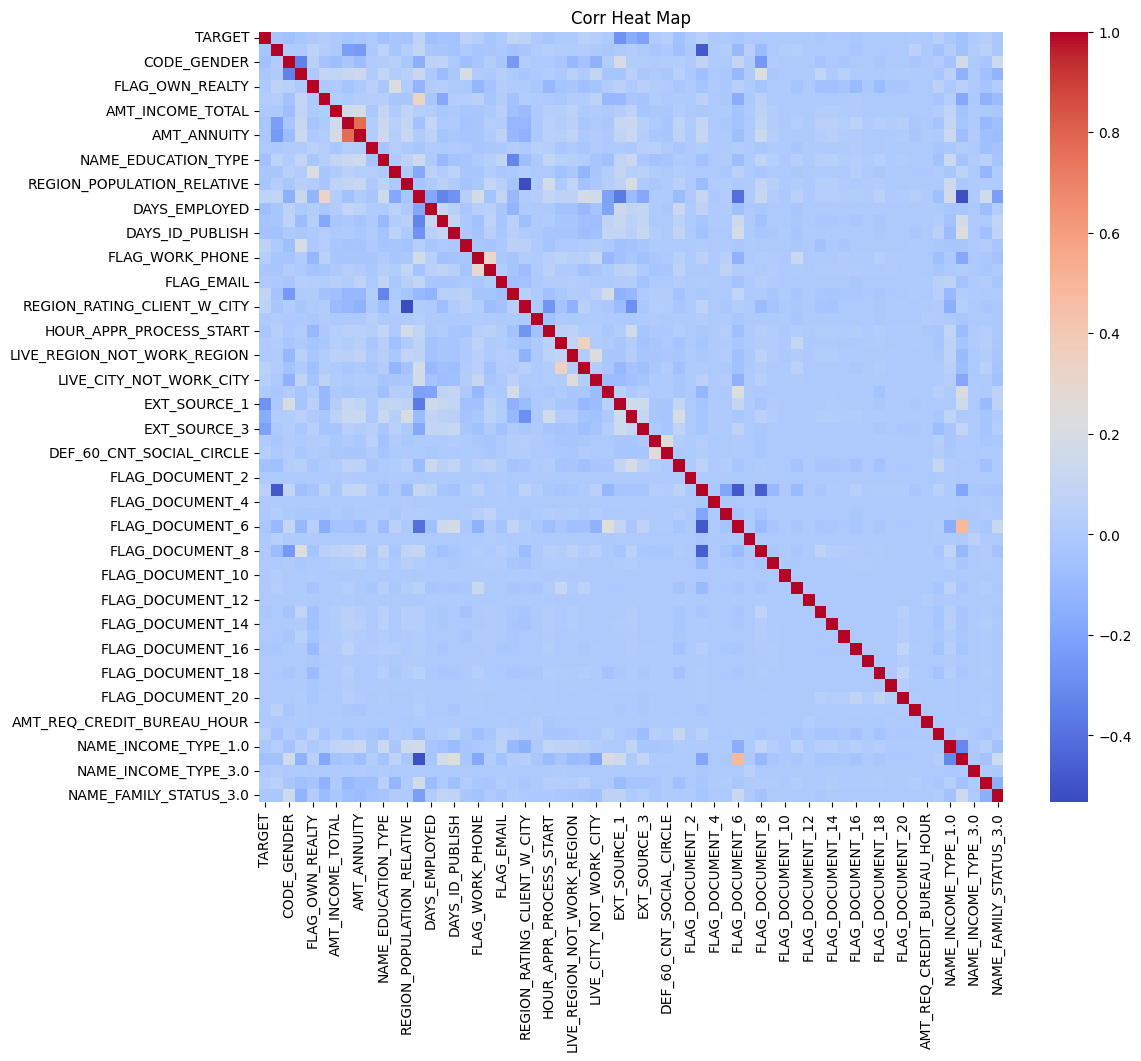

In [4]:
# corr 행렬 계산
corr_matrix = df.corr()
# corr 행렬 히트맵 시각화
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, cmap='coolwarm')
plt.title('Corr Heat Map')
plt.show()

In [5]:
# 타겟 변수와 특성 분리
X = df.drop('TARGET', axis=1)  # 'target'을 실제 타겟 변수 이름으로 변경
y = df['TARGET']


In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=42, 
                                                    stratify=y)


In [7]:
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")

# 인덱스 확인
print(f"X_train index: {X_train.index}")
print(f"y_train index: {y_train.index}")

# 인덱스가 일치하지 않아서, 재설정
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

X_train shape: (246005, 62)
y_train shape: (246005,)
X_train index: Index([204118,  71550, 230283, 307046, 164472,  74753,  59944,  41748, 248778,
        96243,
       ...
       214251,  64395,  92913,  14527, 221002, 142142, 207999, 116985,   8899,
       208886],
      dtype='int64', length=246005)
y_train index: Index([204118,  71550, 230283, 307046, 164472,  74753,  59944,  41748, 248778,
        96243,
       ...
       214251,  64395,  92913,  14527, 221002, 142142, 207999, 116985,   8899,
       208886],
      dtype='int64', length=246005)


## Stepwise 커스텀 - 모델의 예측 성능의 임계값(0.0005)을 넘지 못하면 stop

In [8]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from itertools import combinations

def stepwise_selection(X, y, 
                       model, 
                       scoring='roc_auc', 
                       cv=5, 
                       threshold=0.0005, 
                       max_features=None, 
                       direction='forward'):
    """
    단계적 특징 선택 (Forward 또는 Backward) with Early Stopping

    Parameters:
    - X: 특징 데이터 (DataFrame)
    - y: 타겟 데이터 (Series 또는 ndarray)
    - model: 사용할 모델 (예: LogisticRegression)
    - scoring: 평가 지표 (기본: 'roc_auc')
    - cv: 교차 검증 폴드 수 (기본: 5)
    - threshold: 성능 향상 최소 기준 (기본: 1e-3)
    - max_features: 선택할 최대 특징 수 (기본: None, 모든 특징 사용)
    - direction: 'forward' 또는 'backward' (기본: 'forward')

    Returns:
    - selected_features: 선택된 특징 리스트
    - history: 선택 과정의 성능 기록
    """
    selected_features = []
    remaining_features = list(X.columns)
    best_score = 0
    history = []
    
    while True:
        scores_with_candidates = []
        if direction == 'forward':
            candidates = remaining_features
            for feature in candidates:
                current_features = selected_features + [feature]
                score = np.mean(cross_val_score(model, X[current_features], y, cv=cv, scoring=scoring, n_jobs=-1))
                scores_with_candidates.append((score, feature))
        elif direction == 'backward':
            if not selected_features:
                break
            candidates = selected_features
            for feature in candidates:
                current_features = selected_features.copy()
                current_features.remove(feature)
                score = np.mean(cross_val_score(model, X[current_features], y, cv=cv, scoring=scoring, n_jobs=-1))
                scores_with_candidates.append((score, feature))
        else:
            raise ValueError("direction는 'forward' 또는 'backward' 이어야 합니다.")
        
        if not scores_with_candidates:
            break
        
        # 최고 성능과 해당 특징 찾기
        scores_with_candidates.sort(reverse=True)
        best_new_score, best_candidate = scores_with_candidates[0]
        
        improvement = best_new_score - best_score
        if improvement > threshold:
            selected_features.append(best_candidate) if direction == 'forward' else selected_features.remove(best_candidate)
            remaining_features.remove(best_candidate) if direction == 'forward' else remaining_features.append(best_candidate)
            best_score = best_new_score
            history.append((selected_features.copy(), best_score))
            print(f"특징: {best_candidate}, 향상된 점수: {improvement:.6f}, 현재 점수: {best_score:.6f}")
            if max_features and len(selected_features) >= max_features:
                print("최대 특징 수에 도달하여 중단합니다.")
                break
        else:
            print("성능 향상이 threshold 이하이므로 선택 과정을 중단합니다.")
            break
    
    return selected_features, history

# 로지스틱 회귀 모델 초기화
logreg = LogisticRegression(
    penalty='none',  # 정규화 사용 안함
    solver='lbfgs', 
    max_iter=1000, 
    random_state=42
)

# 단계적 특징 선택 수행 (Forward Selection 예시)
selected_features, history = stepwise_selection(
    X_train, 
    y_train, 
    model=logreg, 
    scoring='roc_auc', 
    cv=2, 
    threshold=1e-3,  # 최소 향상 기준
    max_features=None,  # 최대 특징 수 제한 없음
    direction='forward'  # 'forward' 또는 'backward' 선택
)

print(f"선택된 특성 개수: {len(selected_features)}")
print("선택된 특성들:", selected_features)


특징: EXT_SOURCE_1, 향상된 점수: 0.807590, 현재 점수: 0.807590
특징: EXT_SOURCE_3, 향상된 점수: 0.020591, 현재 점수: 0.828180
특징: EXT_SOURCE_2, 향상된 점수: 0.006205, 현재 점수: 0.834385
특징: OWN_CAR_AGE, 향상된 점수: 0.002488, 현재 점수: 0.836874
특징: DAYS_BIRTH, 향상된 점수: 0.001938, 현재 점수: 0.838812
특징: OCCUPATION_TYPE, 향상된 점수: 0.001302, 현재 점수: 0.840114
특징: FLAG_DOCUMENT_3, 향상된 점수: 0.001302, 현재 점수: 0.841416
성능 향상이 threshold 이하이므로 선택 과정을 중단합니다.
선택된 특성 개수: 7
선택된 특성들: ['EXT_SOURCE_1', 'EXT_SOURCE_3', 'EXT_SOURCE_2', 'OWN_CAR_AGE', 'DAYS_BIRTH', 'OCCUPATION_TYPE', 'FLAG_DOCUMENT_3']


In [9]:
## ['EXT_SOURCE_1', 'EXT_SOURCE_3', 'EXT_SOURCE_2', 'OWN_CAR_AGE', 'DAYS_BIRTH', 'OCCUPATION_TYPE', 'FLAG_DOCUMENT_3']

## 7개 변수 내에서 다중공선성 존재하는지 식별

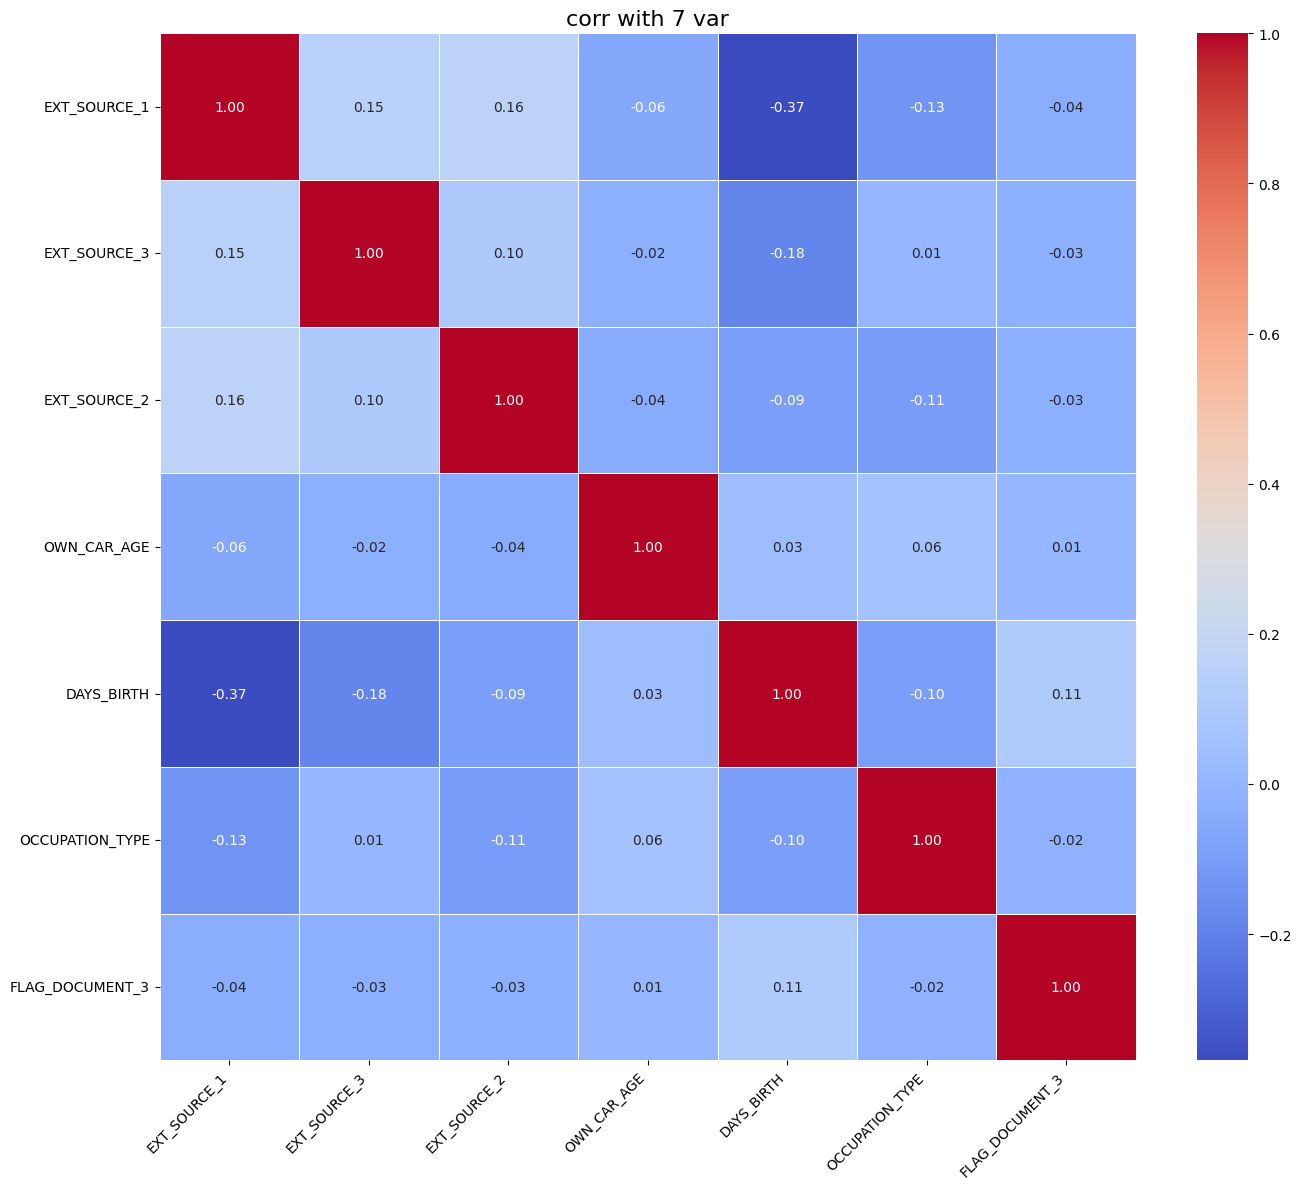

In [10]:
# corr 행렬 계산
corr_matrix = df[selected_features].corr()
# 히트맵 시각화
plt.figure(figsize=(14, 12))
heatmap = sns.heatmap(corr_matrix, 
                      cmap='coolwarm', 
                      annot=True,        # 숫자 값 표시
                      fmt=".2f",         # 소수점 두 자리까지 표시
                      linewidths=0.5,    # 셀 간격
                      linecolor='white') # 셀 간 선 색상

# 제목 설정
plt.title('corr with 7 var', fontsize=16)

# 축 레이블 회전 (필요시)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

# 레이아웃 조정
plt.tight_layout()

# 히트맵 표시
plt.show()

## 선택한 변수들로 재구성

In [11]:
# 선택된 특성을 사용하여 훈련 및 테스트 데이터 재구성
X_train = X_train[selected_features]
X_test = X_test[selected_features]

print("선택된 특성을 사용한 훈련 데이터 크기:", X_train.shape)
print("선택된 특성을 사용한 테스트 데이터 크기:", X_test.shape)


선택된 특성을 사용한 훈련 데이터 크기: (246005, 7)
선택된 특성을 사용한 테스트 데이터 크기: (61502, 7)


## 기본적인 로지스틱회귀 L1 Term

In [12]:
# SMOTE 미적용 로지스틱 회귀 모델 초기화 (L1 정규화)
logreg = LogisticRegression(penalty='l1', 
                            solver='liblinear', 
                            C=1.0, 
                            class_weight='balanced', 
                            random_state=42,
                            max_iter=1000)

# 모델 학습
logreg.fit(X_train, y_train)


LogisticRegression(class_weight='balanced', max_iter=1000, penalty='l1',
                   random_state=42, solver='liblinear')

In [13]:
# 예측 수행
y_pred = logreg.predict(X_test)


In [14]:
# 평가 지표 출력
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("Accuracy:", accuracy_score(y_test, y_pred))


Confusion Matrix:
[[44800 11737]
 [ 1028  3937]]

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.79      0.88     56537
           1       0.25      0.79      0.38      4965

    accuracy                           0.79     61502
   macro avg       0.61      0.79      0.63     61502
weighted avg       0.92      0.79      0.84     61502

Accuracy: 0.7924457741211668


c:\Users\JSH\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 48120 (\N{HANGUL SYLLABLE MI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\JSH\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51201 (\N{HANGUL SYLLABLE JEOG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\JSH\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 50857 (\N{HANGUL SYLLABLE YONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


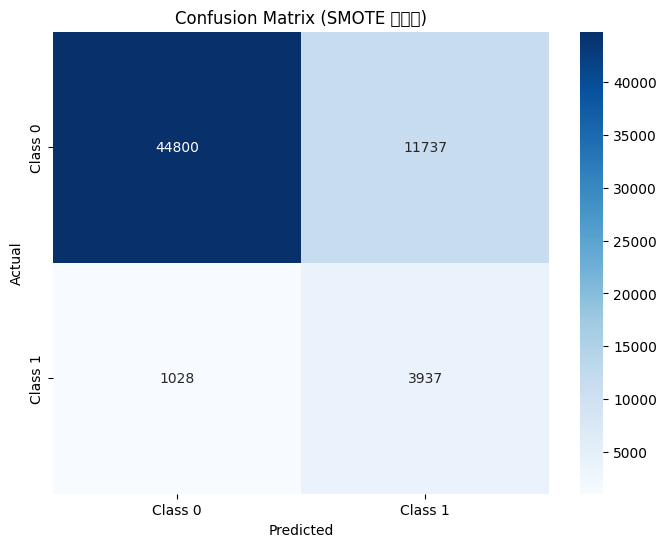

In [15]:
# 혼동 행렬 시각화
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=['Class 0', 'Class 1'], 
            yticklabels=['Class 0', 'Class 1'])
plt.title("Confusion Matrix (SMOTE 미적용)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


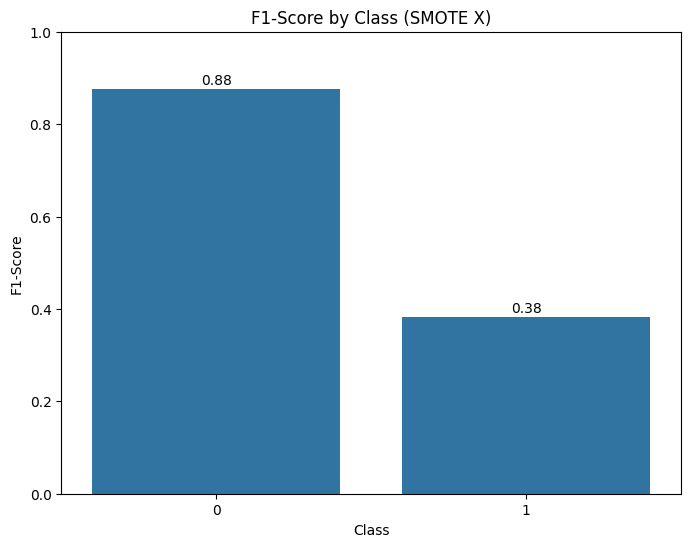

In [16]:
# 분류 보고서 시각화 (Precision, Recall, F1-Score)
report = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose().iloc[:-3, :]  # 전체 클래스만 선택

plt.figure(figsize=(8, 6))
sns.barplot(x=report_df.index, y='f1-score', data=report_df)
plt.title("F1-Score by Class (SMOTE X)")
plt.xlabel("Class")
plt.ylabel("F1-Score")
plt.ylim(0, 1)
for index, value in enumerate(report_df['f1-score']):
    plt.text(index, value + 0.01, f"{value:.2f}", ha='center')
plt.show()


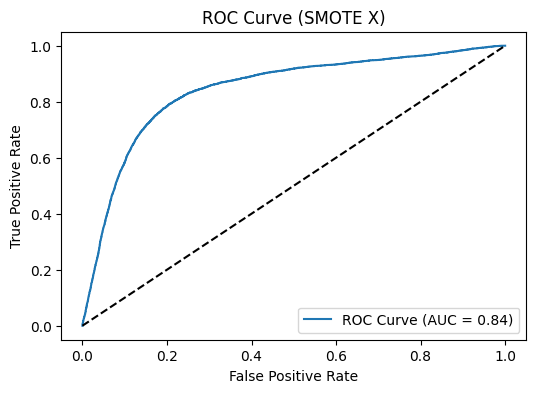

ROC AUC Score: 0.8431


In [17]:
# ROC 커브 시각화
y_proba = logreg.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve (SMOTE X)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc='lower right')
plt.show()

print(f"ROC AUC Score: {roc_auc:.4f}")


## 그리드 서치를 통한 최적의 파라미터 찾기

In [ ]:
# 그리드 서치 파라미터 그리드 정의
param_grid = [
    {
        'penalty': ['l1'],
        'C': [0.01, 0.1, 1, 10, 100],
        'solver': ['liblinear', 'saga'],
    },
    {
        'penalty': ['l2'],
        'C': [0.01, 0.1, 1, 10, 100],
        'solver': ['lbfgs', 'saga'],
    },
    {
        'penalty': ['elasticnet'],
        'C': [0.01, 0.1, 1, 10, 100],
        'solver': ['saga'],
        'l1_ratio': [0.2, 0.5, 0.8],
    }
]

# 그리드 서치 초기화
grid_search = GridSearchCV(LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000),
                           param_grid, 
                           cv=5, 
                           scoring='roc_auc', 
                           n_jobs=-1, 
                           verbose=1)

# 그리드 서치 수행
grid_search.fit(X_train, y_train)

print(f"\n최적 파라미터 (SMOTE 미적용): {grid_search.best_params_}")
print(f"최고 교차 검증 ROC AUC 점수: {grid_search.best_score_:.4f}")


Fitting 5 folds for each of 20 candidates, totalling 100 fits

최적 파라미터 (SMOTE 미적용): {'C': 0.01, 'penalty': 'l1', 'solver': 'liblinear'}
최고 교차 검증 ROC AUC 점수: 0.8448


In [19]:
# 최적 모델을 사용하여 테스트 데이터 예측
best_logreg = grid_search.best_estimator_
y_pred_best = best_logreg.predict(X_test)
y_proba_best = best_logreg.predict_proba(X_test)[:, 1]

# 평가 지표 출력
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_best))

print("\nClassification Report:")
print(classification_report(y_test, y_pred_best))

accuracy_best = accuracy_score(y_test, y_pred_best)
roc_auc_best = roc_auc_score(y_test, y_proba_best)
print(f"Accuracy: {accuracy_best:.4f}")
print(f"ROC AUC Score: {roc_auc_best:.4f}")



Confusion Matrix:
[[44799 11738]
 [ 1027  3938]]

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.79      0.88     56537
           1       0.25      0.79      0.38      4965

    accuracy                           0.79     61502
   macro avg       0.61      0.79      0.63     61502
weighted avg       0.92      0.79      0.84     61502

Accuracy: 0.7924
ROC AUC Score: 0.8432


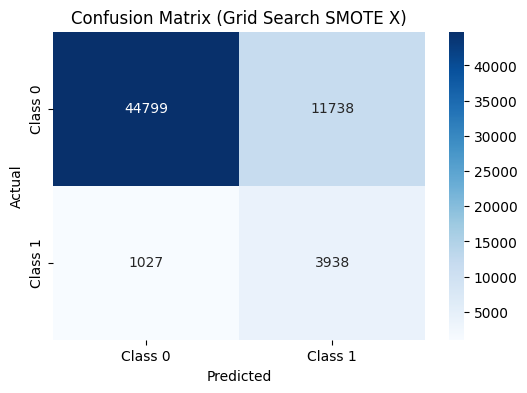

In [20]:
# 혼동 행렬 시각화
cm_best = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_best, annot=True, fmt="d", cmap="Blues", 
            xticklabels=['Class 0', 'Class 1'], 
            yticklabels=['Class 0', 'Class 1'])
plt.title("Confusion Matrix (Grid Search SMOTE X)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


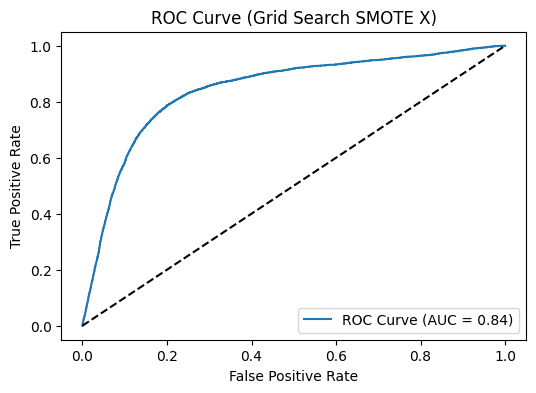

In [21]:
# ROC 커브 시각화
fpr_best, tpr_best, thresholds_best = roc_curve(y_test, y_proba_best)
plt.figure(figsize=(6, 4))
plt.plot(fpr_best, tpr_best, label=f'ROC Curve (AUC = {roc_auc_best:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve (Grid Search SMOTE X)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc='lower right')
plt.show()


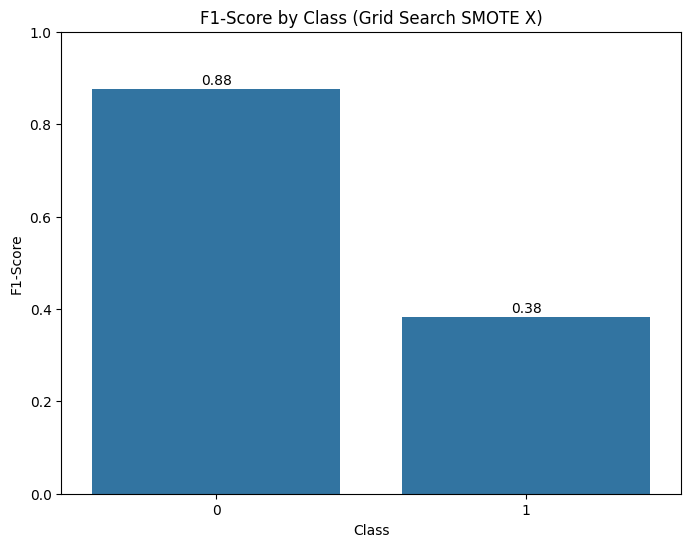

In [22]:
# F1-Score 시각화
report_best = classification_report(y_test, y_pred_best, output_dict=True)
report_df_best = pd.DataFrame(report_best).transpose().iloc[:-3, :]  # 전체 클래스만 선택

plt.figure(figsize=(8, 6))
sns.barplot(x=report_df_best.index, y='f1-score', data=report_df_best)
plt.title("F1-Score by Class (Grid Search SMOTE X)")
plt.xlabel("Class")
plt.ylabel("F1-Score")
plt.ylim(0, 1)
for index, value in enumerate(report_df_best['f1-score']):
    plt.text(index, value + 0.01, f"{value:.2f}", ha='center')
plt.show()


## Prob -> Class 맵핑 확률 임계값 조정

In [ ]:
# 다양한 임계값 설정
thresholds = np.linspace(0.0, 1.0, num=100)

# 성능 지표를 저장할 리스트 초기화
accuracy_list = []
precision_list = []
recall_list = []
f1_list = []
roc_auc_list = []

for thresh in thresholds:
    y_pred_thresh = (y_proba_best >= thresh).astype(int)
    acc = accuracy_score(y_test, y_pred_thresh)
    precision = precision_score(y_test, y_pred_thresh, zero_division=0)
    recall = recall_score(y_test, y_pred_thresh, zero_division=0)
    f1 = f1_score(y_test, y_pred_thresh, zero_division=0)
    roc_auc = roc_auc_score(y_test, y_pred_best)
    
    accuracy_list.append(acc)
    precision_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1)
    roc_auc_list.append(roc_auc)

# 성능 지표를 데이터프레임으로 변환
threshold_metrics = pd.DataFrame({
    'Threshold': thresholds,
    'Accuracy': accuracy_list,
    'Precision': precision_list,
    'Recall': recall_list,
    'F1-Score': f1_list,
    'ROC_AUC': roc_auc_list
})

# ROC_AUC는 임계값에 따라 변하지 않으므로 동일한 값을 가집니다.
# 대신, 다른 지표들의 변화를 시각화합니다.


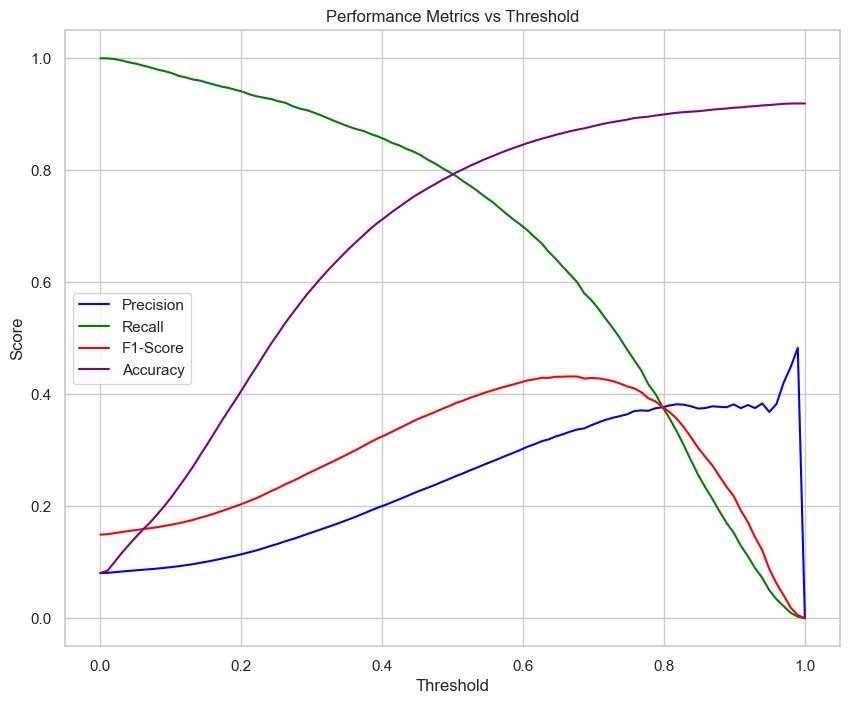

In [36]:
# 성능 지표 시각화
plt.figure(figsize=(10, 8))
plt.plot(threshold_metrics['Threshold'], threshold_metrics['Precision'], label='Precision', color='blue')
plt.plot(threshold_metrics['Threshold'], threshold_metrics['Recall'], label='Recall', color='green')
plt.plot(threshold_metrics['Threshold'], threshold_metrics['F1-Score'], label='F1-Score', color='red')
plt.plot(threshold_metrics['Threshold'], threshold_metrics['Accuracy'], label='Accuracy', color='purple')
plt.title("Performance Metrics vs Threshold")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.legend()
plt.grid(True)
plt.show()


In [27]:
# F1-Score가 최대인 임계값 찾기
max_f1 = threshold_metrics['F1-Score'].max()
best_threshold = threshold_metrics.loc[threshold_metrics['F1-Score'] == max_f1, 'Threshold'].values[0]
print(f"최적 F1-Score 임계값: {best_threshold:.2f}")


최적 F1-Score 임계값: 0.67


In [29]:
# 최적 임계값 적용
y_pred_best_thresh = (y_proba_best >= best_threshold).astype(int)

# 평가 지표 출력
print(f"\nConfusion Matrix (Threshold={best_threshold:.2f}):")
print(confusion_matrix(y_test, y_pred_best_thresh))

print("\nClassification Report:")
print(classification_report(y_test, y_pred_best_thresh))

print(f"Accuracy: {accuracy_score(y_test, y_pred_best_thresh):.4f}")
print(f"ROC AUC Score: {roc_auc_score(y_test, y_proba_best):.4f}")



Confusion Matrix (Threshold=0.67):
[[50436  6101]
 [ 1917  3048]]

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.89      0.93     56537
           1       0.33      0.61      0.43      4965

    accuracy                           0.87     61502
   macro avg       0.65      0.75      0.68     61502
weighted avg       0.91      0.87      0.89     61502

Accuracy: 0.8696
ROC AUC Score: 0.8432


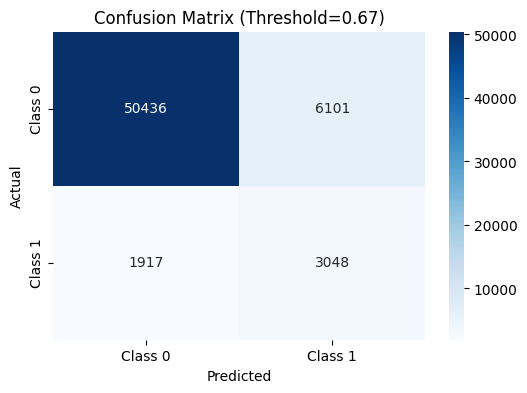

In [30]:

# 혼동 행렬 시각화
cm_thresh = confusion_matrix(y_test, y_pred_best_thresh)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_thresh, annot=True, fmt="d", cmap="Blues", 
            xticklabels=['Class 0', 'Class 1'], 
            yticklabels=['Class 0', 'Class 1'])
plt.title(f"Confusion Matrix (Threshold={best_threshold:.2f})")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


## 증강기법 사용 (SMOTE, Borderline SMOTE, ADASYN)

In [37]:
# 선택된 특성을 사용하여 훈련 및 테스트 데이터 재구성
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

print("선택된 특성을 사용한 훈련 데이터 크기:", X_train_selected.shape)
print("선택된 특성을 사용한 테스트 데이터 크기:", X_test_selected.shape)


선택된 특성을 사용한 훈련 데이터 크기: (246005, 7)
선택된 특성을 사용한 테스트 데이터 크기: (61502, 7)


In [38]:
# SMOTE 적용
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_selected, y_train)

print("SMOTE 적용 후 훈련 데이터 크기:", X_train_smote.shape)
print("SMOTE 적용 후 클래스 분포:", np.bincount(y_train_smote))

# Borderline SMOTE 적용
border_smote = BorderlineSMOTE(random_state=42)
X_train_border_smote, y_train_border_smote = border_smote.fit_resample(X_train_selected, y_train)

print("Borderline SMOTE 적용 후 훈련 데이터 크기:", X_train_border_smote.shape)
print("Borderline SMOTE 적용 후 클래스 분포:", np.bincount(y_train_border_smote))


# ADASYN 적용
adasyn = ADASYN(random_state=42)
X_train_adasyn, y_train_adasyn = adasyn.fit_resample(X_train_selected, y_train)

print("ADASYN 적용 후 훈련 데이터 크기:", X_train_adasyn.shape)
print("ADASYN 적용 후 클래스 분포:", np.bincount(y_train_adasyn))



SMOTE 적용 후 훈련 데이터 크기: (452290, 7)
SMOTE 적용 후 클래스 분포: [226145 226145]
Borderline SMOTE 적용 후 훈련 데이터 크기: (452290, 7)
Borderline SMOTE 적용 후 클래스 분포: [226145 226145]
ADASYN 적용 후 훈련 데이터 크기: (452786, 7)
ADASYN 적용 후 클래스 분포: [226145 226641]


# 그리드서치 L1, L2, elasticnet 정의

In [47]:
# 그리드 서치 파라미터 그리드 정의
param_grid = [
    {
        'penalty': ['l1'],
        'C': [0.01, 0.1, 1, 10, 100],
        'solver': ['liblinear', 'saga'],
    },
    {
        'penalty': ['l2'],
        'C': [0.01, 0.1, 1, 10, 100],
        'solver': ['lbfgs', 'saga'],
    },
    {
        'penalty': ['elasticnet'],
        'C': [0.01, 0.1, 1, 10, 100],
        'solver': ['saga'],
        'l1_ratio': [0.2, 0.5, 0.8],
    }
]


## 1. SMOTE

In [48]:
# 그리드 서치 초기화 (SMOTE)
grid_search_smote = GridSearchCV(
    LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000),
    param_grid, 
    cv=5, 
    scoring='roc_auc', 
    n_jobs=-1, 
    verbose=1
)

# 그리드 서치 수행 (SMOTE)
grid_search_smote.fit(X_train_smote, y_train_smote)

print(f"\n최적 파라미터 (SMOTE 적용): {grid_search_smote.best_params_}")
print(f"최고 교차 검증 ROC AUC 점수: {grid_search_smote.best_score_:.4f}")


Fitting 5 folds for each of 35 candidates, totalling 175 fits

최적 파라미터 (SMOTE 적용): {'C': 0.01, 'penalty': 'l1', 'solver': 'liblinear'}
최고 교차 검증 ROC AUC 점수: 0.8479


In [54]:
# 그리드 서치 결과 확인
results = pd.DataFrame(grid_search_smote.cv_results_)
print(results[['param_penalty', 'param_C', 'param_solver', 'mean_test_score', 'std_test_score']])


   param_penalty param_C param_solver  mean_test_score  std_test_score
0             l1    0.01    liblinear         0.847862        0.000736
1             l1    0.01         saga         0.847856        0.000734
2             l1     0.1    liblinear         0.847837        0.000735
3             l1     0.1         saga         0.847836        0.000734
4             l1       1    liblinear         0.847834        0.000735
5             l1       1         saga         0.847834        0.000735
6             l1      10    liblinear         0.847834        0.000735
7             l1      10         saga         0.847834        0.000735
8             l1     100    liblinear         0.847834        0.000735
9             l1     100         saga         0.847834        0.000735
10            l2    0.01        lbfgs         0.847839        0.000734
11            l2    0.01         saga         0.847839        0.000734
12            l2     0.1        lbfgs         0.847834        0.000734
13    

In [63]:
# 최적 모델 선택 (SMOTE)
best_logreg_smote = grid_search_smote.best_estimator_

# 테스트 데이터 예측 (SMOTE)
y_pred_smote = best_logreg_smote.predict(X_test_selected)
y_proba_smote = best_logreg_smote.predict_proba(X_test_selected)[:, 1]

# 평가 지표 출력 (SMOTE)
print("\nConfusion Matrix (SMOTE 적용):")
print(confusion_matrix(y_test, y_pred_smote))

print("\nClassification Report (SMOTE 적용):")
print(classification_report(y_test, y_pred_smote))

print("Accuracy:", accuracy_score(y_test, y_pred_smote))
print(f"ROC AUC Score: {roc_auc_score(y_test, y_proba_smote):.4f}")



Confusion Matrix (SMOTE 적용):
[[44880 11657]
 [ 1030  3935]]

Classification Report (SMOTE 적용):
              precision    recall  f1-score   support

           0       0.98      0.79      0.88     56537
           1       0.25      0.79      0.38      4965

    accuracy                           0.79     61502
   macro avg       0.61      0.79      0.63     61502
weighted avg       0.92      0.79      0.84     61502

Accuracy: 0.7937140255601444
ROC AUC Score: 0.8432


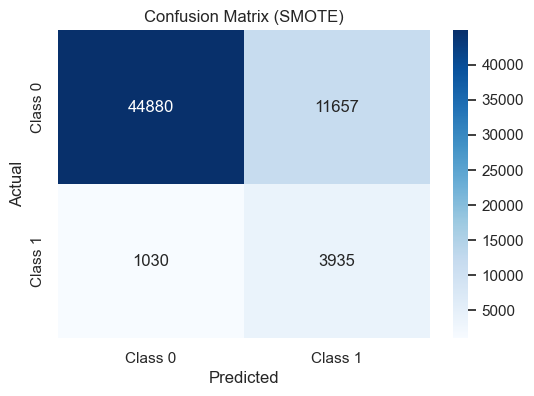

In [66]:

# 혼동 행렬 시각화
cm_smote = confusion_matrix(y_test, y_pred_smote)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_smote, annot=True, fmt="d", cmap="Blues", 
            xticklabels=['Class 0', 'Class 1'], 
            yticklabels=['Class 0', 'Class 1'])
plt.title("Confusion Matrix (SMOTE)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


## 2. BorderLine SMOTE

In [50]:
# 그리드 서치 초기화 (Borderline SMOTE)
grid_search_border_smote = GridSearchCV(
    LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000),
    param_grid, 
    cv=5, 
    scoring='roc_auc', 
    n_jobs=-1, 
    verbose=1
)

# 그리드 서치 수행 (Borderline SMOTE)
grid_search_border_smote.fit(X_train_border_smote, y_train_border_smote)

print(f"\n최적 파라미터 (Borderline SMOTE 적용): {grid_search_border_smote.best_params_}")
print(f"최고 교차 검증 ROC AUC 점수: {grid_search_border_smote.best_score_:.4f}")


Fitting 5 folds for each of 35 candidates, totalling 175 fits

최적 파라미터 (Borderline SMOTE 적용): {'C': 0.01, 'penalty': 'l1', 'solver': 'liblinear'}
최고 교차 검증 ROC AUC 점수: 0.8173


In [55]:
# 그리드 서치 결과 확인
results = pd.DataFrame(grid_search_border_smote.cv_results_)
print(results[['param_penalty', 'param_C', 'param_solver', 'mean_test_score', 'std_test_score']])


   param_penalty param_C param_solver  mean_test_score  std_test_score
0             l1    0.01    liblinear         0.817343        0.003412
1             l1    0.01         saga         0.817341        0.003424
2             l1     0.1    liblinear         0.817313        0.003415
3             l1     0.1         saga         0.817312        0.003417
4             l1       1    liblinear         0.817310        0.003416
5             l1       1         saga         0.817309        0.003417
6             l1      10    liblinear         0.817310        0.003416
7             l1      10         saga         0.817309        0.003417
8             l1     100    liblinear         0.817310        0.003416
9             l1     100         saga         0.817309        0.003417
10            l2    0.01        lbfgs         0.817308        0.003410
11            l2    0.01         saga         0.817308        0.003410
12            l2     0.1        lbfgs         0.817309        0.003416
13    

In [58]:
# 최적 모델 선택 (Borderline SMOTE)
best_logreg_border_smote = grid_search_border_smote.best_estimator_

# 테스트 데이터 예측 (Borderline SMOTE)
y_pred_border_smote = best_logreg_border_smote.predict(X_test_selected)
y_proba_border_smote = best_logreg_border_smote.predict_proba(X_test_selected)[:, 1]

# 평가 지표 출력 (Borderline SMOTE)
print("\nConfusion Matrix (Borderline SMOTE 적용):")
print(confusion_matrix(y_test, y_pred_border_smote))

print("\nClassification Report (Borderline SMOTE 적용):")
print(classification_report(y_test, y_pred_border_smote))

print("Accuracy:", accuracy_score(y_test, y_pred_border_smote))
print(f"ROC AUC Score: {roc_auc_score(y_test, y_proba_border_smote):.4f}")



Confusion Matrix (Borderline SMOTE 적용):
[[44198 12339]
 [  941  4024]]

Classification Report (Borderline SMOTE 적용):
              precision    recall  f1-score   support

           0       0.98      0.78      0.87     56537
           1       0.25      0.81      0.38      4965

    accuracy                           0.78     61502
   macro avg       0.61      0.80      0.62     61502
weighted avg       0.92      0.78      0.83     61502

Accuracy: 0.784072062697148
ROC AUC Score: 0.8376


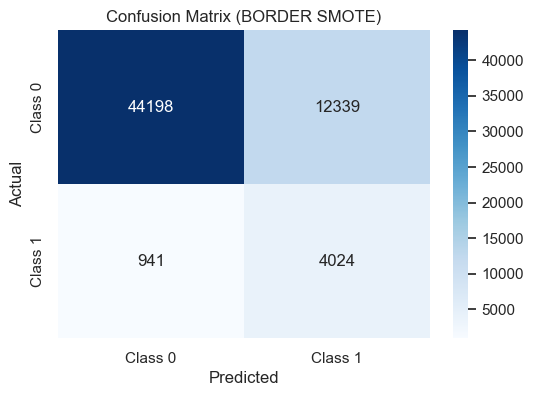

In [71]:
# 혼동 행렬 시각화
cm_smote_border = confusion_matrix(y_test, y_pred_border_smote)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_smote_border, annot=True, fmt="d", cmap="Blues", 
            xticklabels=['Class 0', 'Class 1'], 
            yticklabels=['Class 0', 'Class 1'])
plt.title("Confusion Matrix (BORDER SMOTE)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


## 3. ADASYN

In [52]:
# 그리드 서치 초기화 (ADASYN)
grid_search_adasyn = GridSearchCV(
    LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000),
    param_grid, 
    cv=5, 
    scoring='roc_auc', 
    n_jobs=-1, 
    verbose=1
)

# 그리드 서치 수행 (ADASYN)
grid_search_adasyn.fit(X_train_adasyn, y_train_adasyn)

print(f"\n최적 파라미터 (ADASYN 적용): {grid_search_adasyn.best_params_}")
print(f"최고 교차 검증 ROC AUC 점수: {grid_search_adasyn.best_score_:.4f}")


Fitting 5 folds for each of 35 candidates, totalling 175 fits

최적 파라미터 (ADASYN 적용): {'C': 0.01, 'penalty': 'l1', 'solver': 'liblinear'}
최고 교차 검증 ROC AUC 점수: 0.7798


In [53]:
# 그리드 서치 결과 확인
results = pd.DataFrame(grid_search_adasyn.cv_results_)
print(results[['param_penalty', 'param_C', 'param_solver', 'mean_test_score', 'std_test_score']])


   param_penalty param_C param_solver  mean_test_score  std_test_score
0             l1    0.01    liblinear         0.779751        0.011418
1             l1    0.01         saga         0.779746        0.011432
2             l1     0.1    liblinear         0.779706        0.011426
3             l1     0.1         saga         0.779705        0.011429
4             l1       1    liblinear         0.779701        0.011427
5             l1       1         saga         0.779700        0.011429
6             l1      10    liblinear         0.779701        0.011427
7             l1      10         saga         0.779700        0.011429
8             l1     100    liblinear         0.779701        0.011427
9             l1     100         saga         0.779700        0.011429
10            l2    0.01        lbfgs         0.779706        0.011424
11            l2    0.01         saga         0.779707        0.011424
12            l2     0.1        lbfgs         0.779700        0.011427
13    

In [59]:
# 최적 모델 선택 (ADASYN)
best_logreg_adasyn = grid_search_adasyn.best_estimator_

# 테스트 데이터 예측 (ADASYN)
y_pred_adasyn = best_logreg_adasyn.predict(X_test_selected)
y_proba_adasyn = best_logreg_adasyn.predict_proba(X_test_selected)[:, 1]

# 평가 지표 출력 (ADASYN)
print("\nConfusion Matrix (ADASYN 적용):")
print(confusion_matrix(y_test, y_pred_adasyn))

print("\nClassification Report (ADASYN 적용):")
print(classification_report(y_test, y_pred_adasyn))

print("Accuracy:", accuracy_score(y_test, y_pred_adasyn))
print(f"ROC AUC Score: {roc_auc_score(y_test, y_proba_adasyn):.4f}")



Confusion Matrix (ADASYN 적용):
[[42111 14426]
 [ 1005  3960]]

Classification Report (ADASYN 적용):
              precision    recall  f1-score   support

           0       0.98      0.74      0.85     56537
           1       0.22      0.80      0.34      4965

    accuracy                           0.75     61502
   macro avg       0.60      0.77      0.59     61502
weighted avg       0.92      0.75      0.80     61502

Accuracy: 0.749097590322266
ROC AUC Score: 0.8301


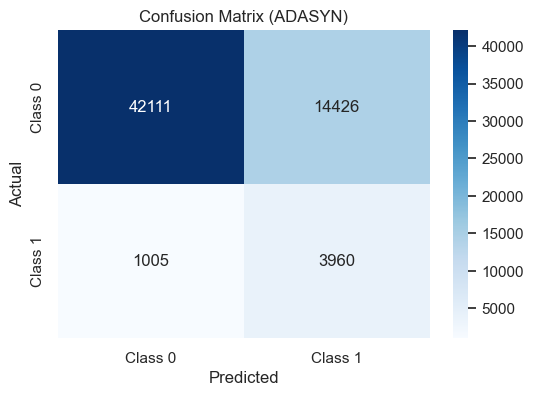

In [70]:
# 혼동 행렬 시각화
cm_adasyn = confusion_matrix(y_test, y_pred_adasyn)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_adasyn, annot=True, fmt="d", cmap="Blues", 
            xticklabels=['Class 0', 'Class 1'], 
            yticklabels=['Class 0', 'Class 1'])
plt.title("Confusion Matrix (ADASYN)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
